# Project Gutenberg Analysis: Subject Analysis

### Notebook 04: Subject Analysis

## Overview
In this notebook, I will look at the subjects of each book to draw insights from the dataset, working in both Python and Excel as appropriate.

## Setup and Imports

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations

# Set up the plotting style
sns.set_theme()

## Data Loading and Initial Processing
After doing the cleaning in Excel, why am I reverting to Python? This image shows a selection of subjects in Excel:

![Excel preview](../src/Screenshots/Subjects_Excel.png)

The subjects are separated by semicolon, with the '--' indicating a sub-category of subject. To complete the analysis, I need these to be in separate dimensions rather than as a string. Excel is fantastic in so many ways, however Python will outperform this complex task in a large dataset.

### Load the Dataset


In [5]:
# Load the raw data
df = pd.read_csv('../data/processed/gutenberg_cleaned_v1.csv', encoding='cp1252')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (74896, 13)


/var/folders/11/kxlf585x3sx77xpyt3j79cbh0000gn/T/ipykernel_20325/460220417.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed/gutenberg_cleaned_v1.csv', encoding='cp1252')


,id,title,authors,languages,download_count,subjects,bookshelves,copyright,author_count,language_count,first_language,second_language,third_language
0,16119,Doctrina Christiana: The first book printed in...,NaN,en; es; tl,4404,Block books -- Facsimiles; Catholic Church -- ...,Browsing: History - General; Browsing: Languag...,False,0,3,en,es,tl
1,20738,Diccionario Ingles-Español-Tagalog: Con partes...,"Calderón, Sofronio G.",en; es; tl,2138,English language -- Dictionaries -- Polyglot; ...,Browsing: Encyclopedias/Dictionaries/Reference...,False,1,3,en,es,tl
2,27035,Entretiens / Interviews / Entrevistas,"Lebert, Marie",en; es; fr,372,Internet; World Wide Web,Browsing: Computers & Technology; Browsing: Sc...,True,1,3,en,es,fr
3,66595,Monumentum Ancyranum: The Deeds of Augustus,"Augustus, Emperor of Rome",el; en; la,179,"Augustus, Emperor of Rome, 63 B.C.-14 A.D.; Ro...",Browsing: History - Ancient; Browsing: History...,False,1,3,el,en,la
4,34731,40 years / 40 años / 40 ans,"Lebert, Marie",en; es; fr,154,Project Gutenberg,Browsing: Encyclopedias/Dictionaries/Reference...,True,1,3,en,es,fr


### Process Subject Fields
The next function will split the subjects

In [10]:
def split_subjects(df):
    """
    Split the subjects into main subjects and sub-subjects
    Returns processed dataframe
    """
    # Create copy to avoid modifying original
    df_processed = df.copy()
    
    # Fill NaN values with empty string before splitting
    df_processed['subjects'] = df_processed['subjects'].fillna('')
    
    # Split subjects into lists
    df_processed['subject_list'] = df_processed['subjects'].str.split(';')
    
    # Separate main subjects and sub-subjects, handling empty strings
    df_processed['main_subjects'] = df_processed['subject_list'].apply(
        lambda x: [s.split('--')[0].strip() for s in x if s != '']
    )
    
    df_processed['sub_subjects'] = df_processed['subject_list'].apply(
        lambda x: [s.split('--')[1].strip() for s in x if '--' in s and s != '']
    )
    
    return df_processed

# Process the dataframe
df_processed = split_subjects(df)

# Display sample of processed subjects
df_processed[['subjects', 'main_subjects', 'sub_subjects']].head()


,subjects,main_subjects,sub_subjects
0,Block books -- Facsimiles; Catholic Church -- ...,"[Block books, Catholic Church, Catholic Church...","[Facsimiles, Catechisms, Catechisms, Texts]"
1,English language -- Dictionaries -- Polyglot; ...,"[English language, English language, English l...","[Dictionaries, Dictionaries, Dictionaries]"
2,Internet; World Wide Web,"[Internet, World Wide Web]",[]
3,"Augustus, Emperor of Rome, 63 B.C.-14 A.D.; Ro...","[Augustus, Emperor of Rome, 63 B.C.-14 A.D., R...",[History]
4,Project Gutenberg,[Project Gutenberg],[]


## Popular Subjects Analysis

### Calculate Subject Metrics

In [52]:
def get_df(df):
    """
    Calculate frequency and download metrics for subjects
    """
    # Get frequency counts
    subject_counts = df.explode('main_subjects')['main_subjects'].value_counts()
    
    # Calculate total downloads per subject
    downloads_per_subject = df.explode('main_subjects').groupby('main_subjects')['download_count'].sum()
    
    # Combine metrics
    metrics = pd.DataFrame({
        'frequency': subject_counts,
        'total_downloads': downloads_per_subject
    })
    
    # Calculate popularity score
    metrics['popularity_score'] = (
        metrics['frequency'] * metrics['total_downloads'] /
        (metrics['frequency'].max() * metrics['total_downloads'].max())
    )
    
    return metrics
pd.options.display.float_format = '{:.2f}'.format
subject_metrics = get_subject_metrics(df_processed)
subject_metrics.sort_values(by='frequency',ascending=False,inplace=True)
subject_metrics.head(10)

,frequency,total_downloads,popularity_score
main_subjects,,,
Science fiction,3227,548605,0.81
Short stories,3005,376934,0.52
United States,2740,371110,0.46
Fiction,2014,190431,0.17
Great Britain,1966,326844,0.29
"World War, 1914-1918",1864,206733,0.18
England,1682,680111,0.52
France,1603,330211,0.24
Adventure stories,1584,395402,0.29


### Visualize Top Subjects

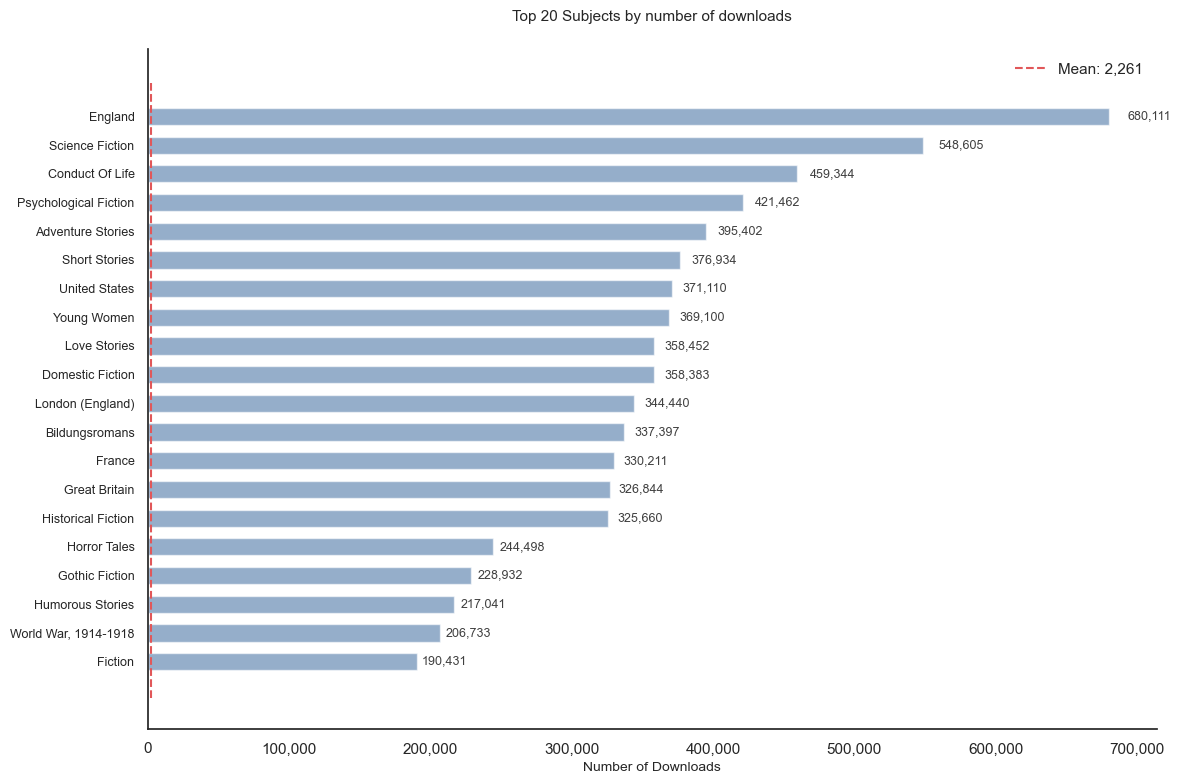

In [25]:
def plot_top_subjects(df, n):
    # Set up the style
    sns.set_theme(style="white")
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get top n subjects
    plot_data = df.sort_values('total_downloads', ascending=True).tail(n)
    
    # Create horizontal bars
    bars = ax.barh(
        range(len(plot_data)),
        plot_data['total_downloads'],
        color='#4e79a7',
        alpha=0.6,
        height=0.6
    )
    
    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(
            width * 1.02,
            i,
            f'{width:,.0f}',
            va='center',
            fontsize=9,
            color='#404040'
        )
    
    # Customize axes
    ax.set_title('Top 20 Subjects by number of downloads', pad=20, fontsize=11)
    ax.set_xlabel('Number of Downloads', fontsize=10)

    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    # Set y-axis labels
    ax.set_yticks(range(len(plot_data)))
    ax.set_yticklabels(
        [subject.title() for subject in plot_data.index],
        fontsize=9
    )
    
    # Remove gridlines
    ax.grid(False)
    
    # Add mean downloads line
    mean_downloads = df['total_downloads'].mean()
    ymin, ymax = ax.get_ylim()
    ax.vlines(
        mean_downloads,
        ymin,
        ymax,
        colors='#e15759',
        linestyles='--',
        label=f'Mean: {mean_downloads:,.0f}'
    )
    
    # Add legend
    ax.legend(frameon=False)
    
    plt.tight_layout()
    plt.savefig(f'../visualisations/subject_metrics_top{n}.png', dpi=300, bbox_inches='tight')
    return fig
    

# Usage:
fig = plot_top_subjects(subject_metrics,20)

plt.show()

The download patterns in Project Gutenberg's collection reveal clear thematic preferences among readers. The most frequently downloaded subjects suggest a strong interest in classic literature and foundational texts, with fiction categories dominating the top rankings. What's particularly interesting is that despite Project Gutenberg's reputation as a historical text archive, contemporary-relevant subjects show significant download activity. The mean download line serves as a key reference point, highlighting how certain subjects dramatically outperform the average, indicating highly concentrated reader interest in specific topics. This distribution pattern suggests that while Project Gutenberg offers a vast array of subjects, user engagement clusters around a core set of traditional literary categories, likely driven by academic use, classic literature enthusiasts, and the enduring appeal of certain genres. The significant gap between the most-downloaded subjects and the mean also indicates that while Project Gutenberg maintains a comprehensive collection, user interaction is notably skewed toward a select group of subjects, possibly reflecting both educational curriculum needs and popular reading preferences in the public domain.

## Subject Co-occurrence Analysis

### Calculate Co-occurrences

In [26]:
def analyze_cooccurrence(df):
    """
    Analyze which subjects frequently appear together
    """
    # Get subject pairs
    subject_pairs = []
    for subjects in df['main_subjects']:
        pairs = list(combinations(sorted(subjects), 2))
        subject_pairs.extend(pairs)
    
    # Count occurrences
    pair_counts = Counter(subject_pairs)
    
    # Convert to DataFrame
    cooc_df = pd.DataFrame([
        {'subject1': s1, 'subject2': s2, 'count': count}
        for (s1, s2), count in pair_counts.items()
    ])
    
    return cooc_df

cooc_df = analyze_cooccurrence(df_processed)
cooc_df.sort_values('count', ascending=False).head(10)

,subject1,subject2,count
171,Science fiction,Short stories,1709
1891,United States,United States,587
5490,Great Britain,Great Britain,474
3659,Human-alien encounters,Science fiction,447
6202,"World War, 1914-1918","World War, 1914-1918",396
5123,Children,Conduct of life,349
5187,France,France,347
1828,Adventure stories,Science fiction,289
8192,Human-alien encounters,Short stories,283
6094,Christian life,Conduct of life,230


The co-occurrence patterns in Project Gutenberg's collection provide fascinating insights into how literary themes intersect in historical publishing. Most notably, Science Fiction emerges as a highly interconnected genre, forming strong bonds with both Short Stories and Adventure Stories, suggesting that early science fiction often found its home in shorter formats and adventure-oriented narratives. The frequent pairing of "Human-alien encounters" with both "Science fiction" and "Short stories" further reinforces this pattern, indicating that early speculative fiction about extraterrestrial contact was predominantly explored through these formats.
The geographic co-occurrences (United States-United States, Great Britain-Great Britain, France-France) aren't errors but likely indicate works that discuss multiple aspects of these countries' histories, cultures, or regions. The significant presence of "World War, 1914-1918" paired with itself suggests extensive coverage of different aspects of WWI, possibly including both military and social histories.
There's also a notable moral/educational thread in the corpus, shown by the strong connection between "Children" and "Conduct of life," as well as "Christian life" and "Conduct of life," reflecting the significant role of moral instruction in historical children's literature and religious texts. This pattern aligns with the educational and moral improvement goals of many historical publishing efforts.

### Create Co-occurrence Network

To visually represent this, here is a co-occurence network. A co-occurrence network is a visual representation that shows how different elements (in this case, subjects) appear together in a dataset. Each node represents a subject, and the lines (edges) connecting them show how often they appear together. The thickness of the lines often represents the frequency of co-occurrence.

In [32]:
def plot_core_subject_network(cooc_df, figsize=(15, 15)):
    """
    Create a network visualization focusing on strong subject co-occurrences (>100)
    """
    sns.set_theme(style="whitegrid")
    sns.set_style("white")
    
    plt.figure(figsize=figsize, facecolor='white')
    
    # Create graph with only strong connections
    G = nx.Graph()
    significant_pairs = cooc_df[cooc_df['count'] >= 100]
    max_count = significant_pairs['count'].max()
    
    # Add edges with normalized weights
    for _, row in significant_pairs.iterrows():
        G.add_edge(
            row['subject1'], 
            row['subject2'], 
            weight=row['count'],
            width=5 * row['count'] / max_count  # Increased base width for better visibility
        )
    
    # Calculate node sizes based on degree centrality
    centrality = nx.degree_centrality(G)
    node_sizes = [v * 5000 for v in centrality.values()]  # Increased node size multiplier
    
    # Use spring layout with adjusted parameters for fewer nodes
    pos = nx.spring_layout(G, k=2, iterations=100, seed=42)  # Increased k for more spread
    
    # Draw edges
    edges = nx.draw_networkx_edges(
        G, pos,
        alpha=0.5,  # Increased alpha for better visibility
        edge_color='#666666',
        width=[G[u][v]['width'] for u, v in G.edges()]
    )
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color='#4e79a7',
        alpha=0.7
    )
    
    # Add labels with larger font size
    labels = nx.draw_networkx_labels(
        G, pos,
        font_size=10,  # Increased font size
        font_weight='bold',
        font_color='#333333'
    )
    
    plt.axis('off')
    
    plt.title('Core Subject Relationships in Project Gutenberg\n', 
              fontsize=14, 
              pad=20,
              fontweight='bold')
    
    # Add more detailed annotations
    plt.figtext(
        0.02, 0.02,
        'Shows subject pairs co-occurring >100 times\n' +
        'Node size: Overall connectivity\n' +
        'Edge thickness: Co-occurrence frequency',
        fontsize=9,
        alpha=0.8
    )
    
    plt.tight_layout()
    return plt.gcf()


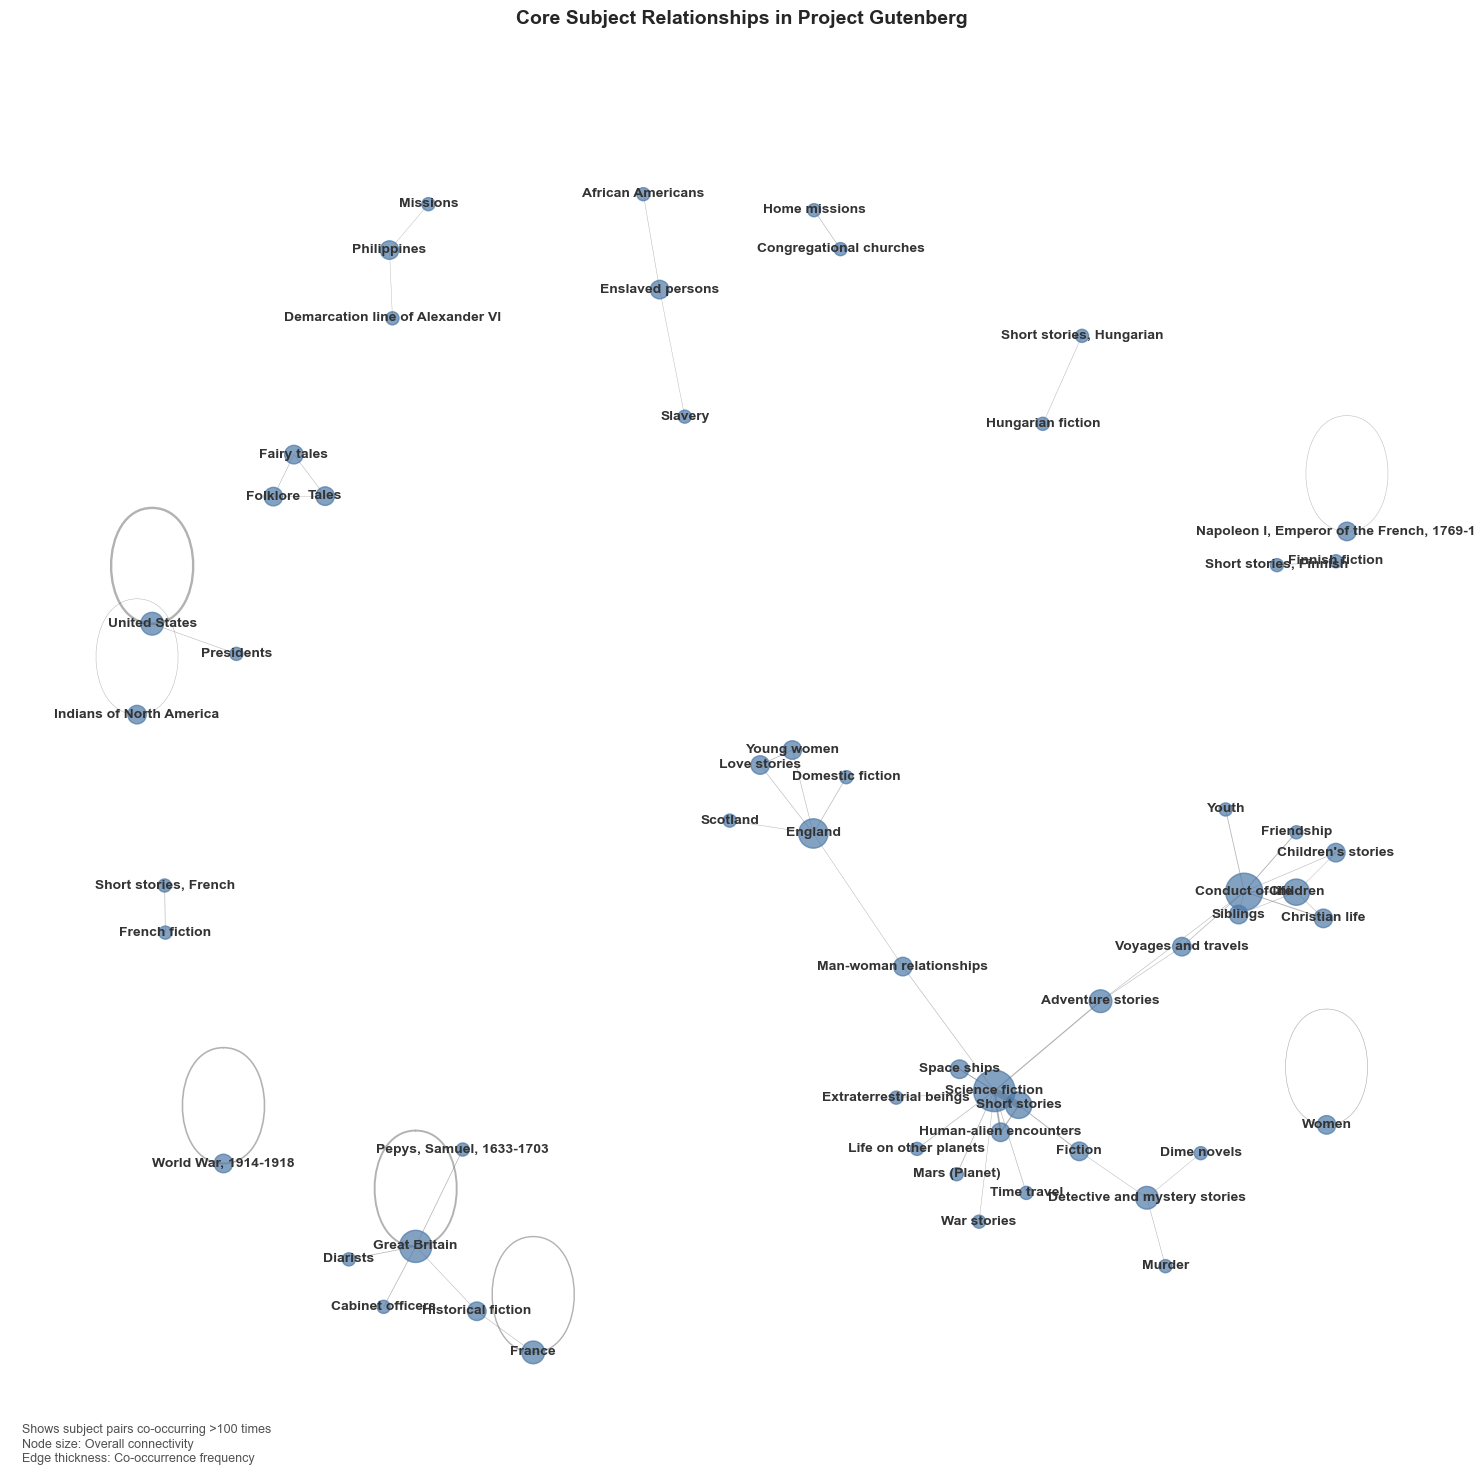

In [33]:
fig = plot_core_subject_network(cooc_df)
plt.savefig('../visualisations/core_subject_network_100.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')
plt.show()

In [34]:
def plot_subject_network(cooc_df, min_count, figsize=(15, 15)):
    """
    Create an enhanced network visualization of subject co-occurrences
    """
    # Set style using seaborn's whitegrid
    sns.set_theme(style="whitegrid")
    sns.set_style("white")  # This removes the grid
    
    # Create figure
    plt.figure(figsize=figsize, facecolor='white')
    
    # Create graph
    G = nx.Graph()
    
    # Filter for significant connections and add edges
    significant_pairs = cooc_df[cooc_df['count'] >= min_count]
    max_count = significant_pairs['count'].max()
    
    # Add edges with normalized weights
    for _, row in significant_pairs.iterrows():
        G.add_edge(
            row['subject1'], 
            row['subject2'], 
            weight=row['count'],
            width=3 * row['count'] / max_count
        )
    
    # Calculate node sizes based on degree centrality
    centrality = nx.degree_centrality(G)
    node_sizes = [v * 3000 for v in centrality.values()]
    
    # Use a more sophisticated layout
    pos = nx.spring_layout(G, k=1, iterations=50, seed=42)
    
    # Draw edges with alpha based on weight
    edges = nx.draw_networkx_edges(
        G, pos,
        alpha=0.4,
        edge_color='#666666',
        width=[G[u][v]['width'] for u, v in G.edges()]
    )
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color='#4e79a7',
        alpha=0.7
    )
    
    # Add labels with better formatting
    labels = nx.draw_networkx_labels(
        G, pos,
        font_size=8,
        font_weight='bold',
        font_color='#333333'
    )
    
    # Remove axes
    plt.axis('off')
    
    # Add title and legend
    plt.title('Subject Co-occurrence Network\n', 
              fontsize=14, 
              pad=20,
              fontweight='bold')
    
    # Add annotations
    plt.figtext(
        0.02, 0.02,
        f'Node size: Connectivity degree\nEdge thickness: Co-occurrence frequency\nMin. co-occurrences: {min_count}',
        fontsize=8,
        alpha=0.7
    )
    
    plt.tight_layout()
    return plt.gcf()


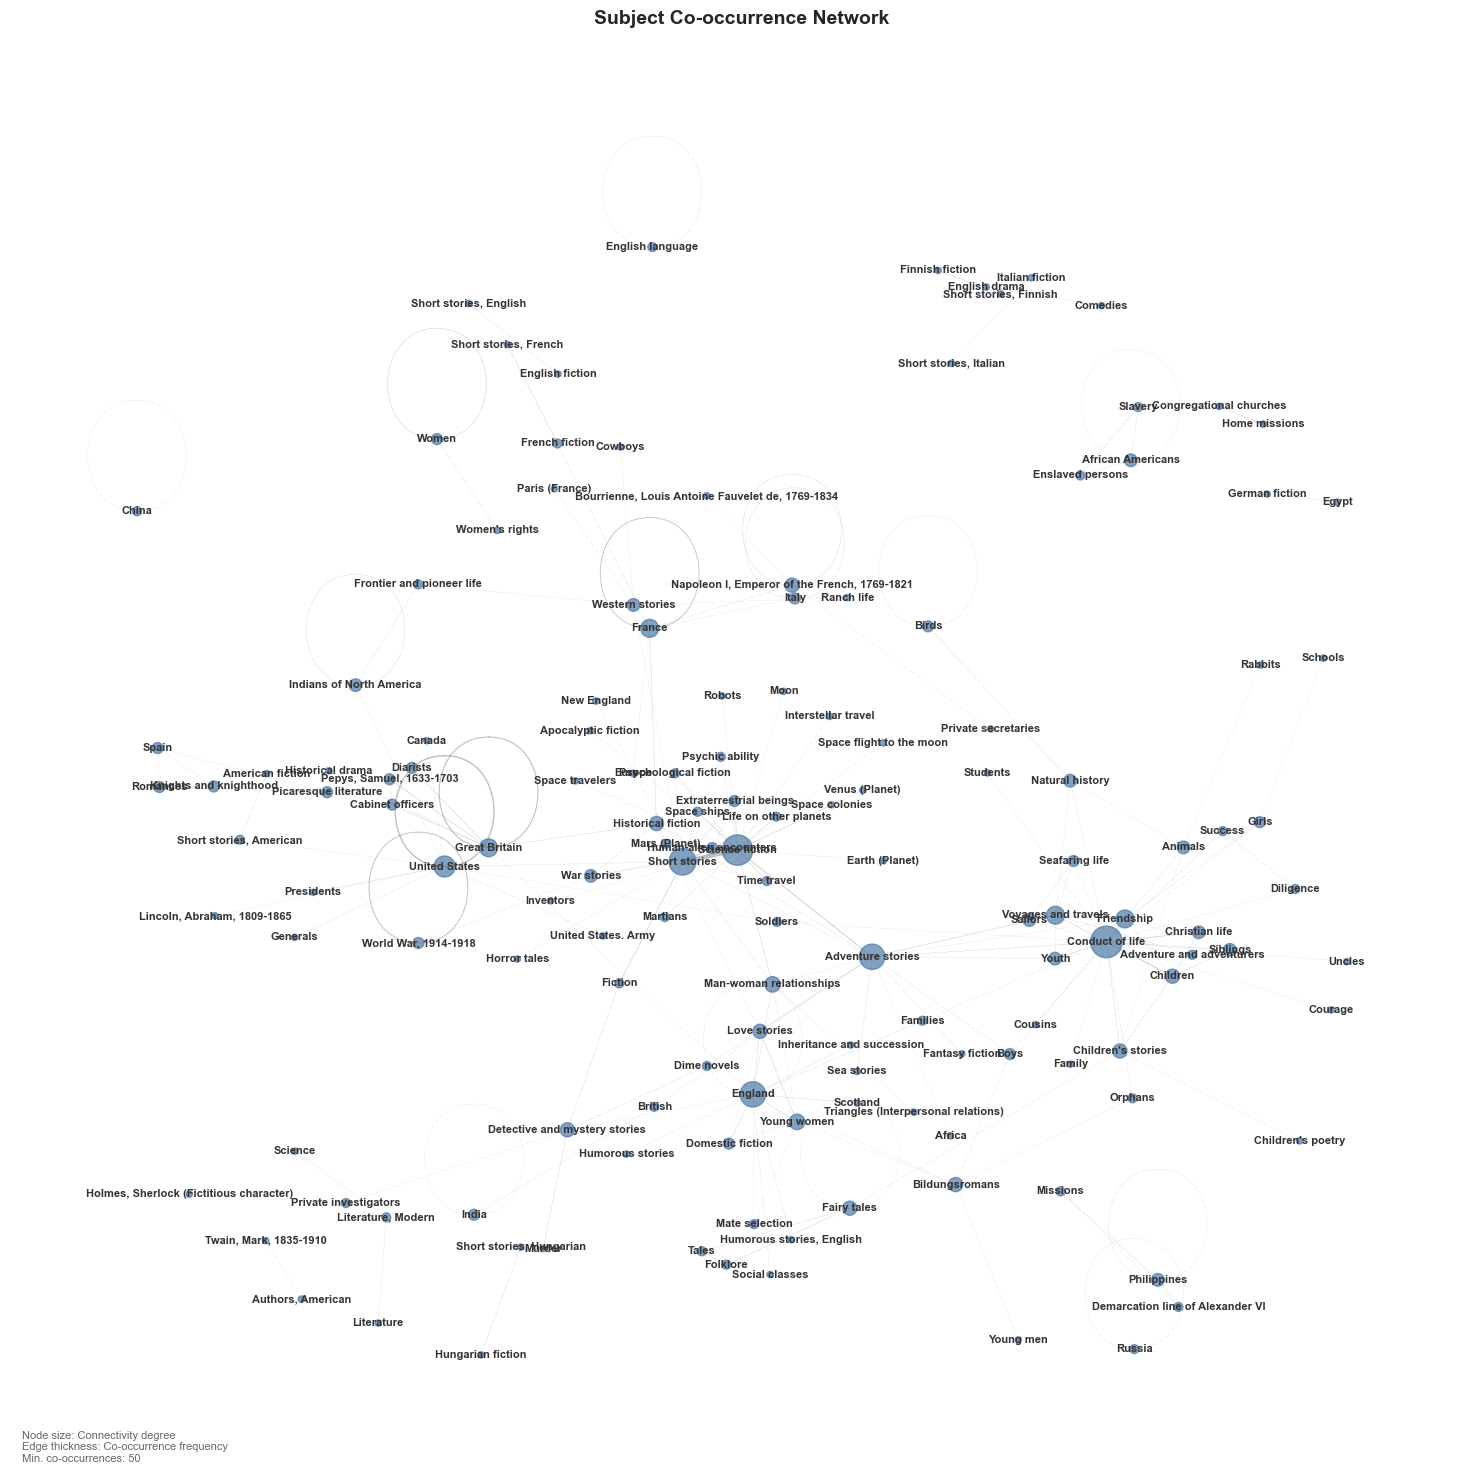

In [35]:
fig = plot_subject_network(cooc_df,50)
plt.savefig('../visualisations/subject_network.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')
plt.show()

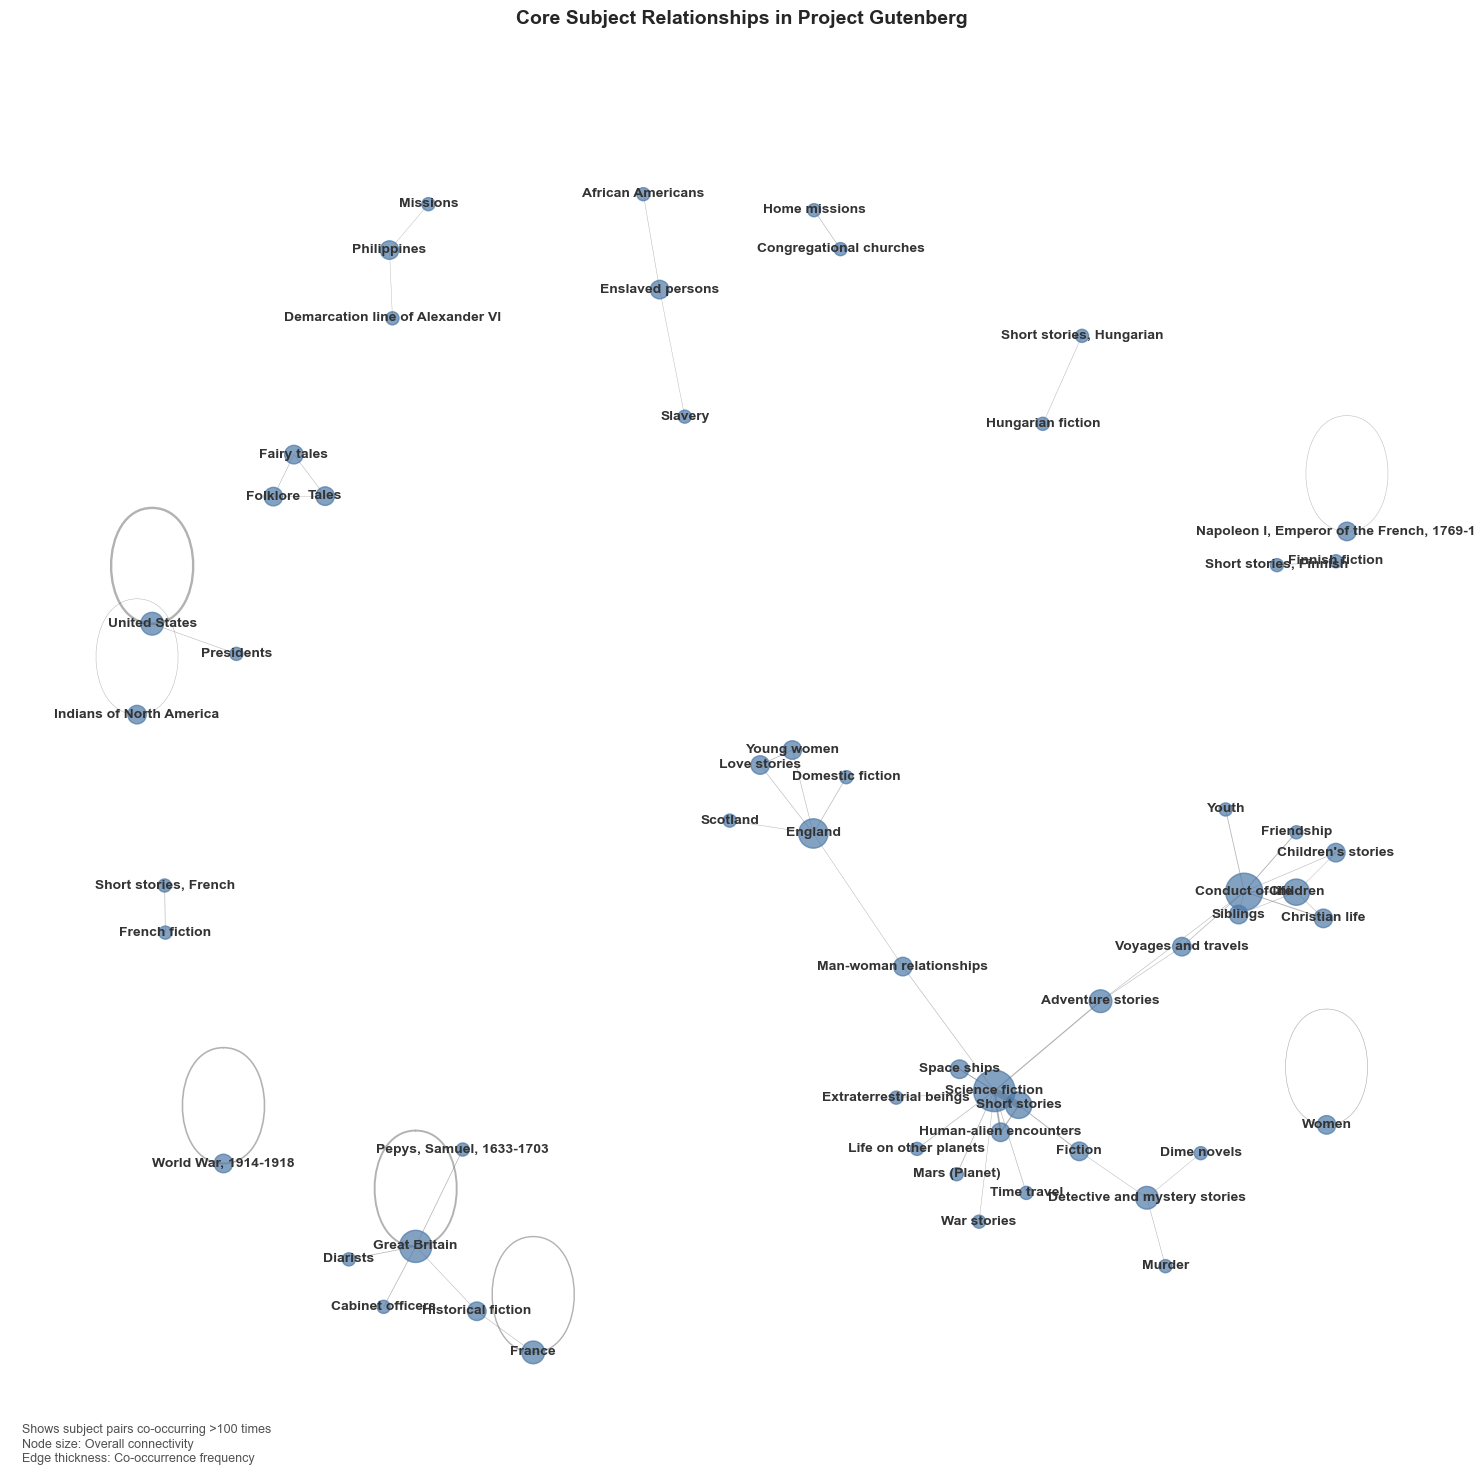

In [36]:
fig = plot_core_subject_network(cooc_df)
plt.savefig('../visualisations/core_subject_network_50.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white')
plt.show()

These two network visualizations provide fascinating insights into the content structure of Project Gutenberg's collection, with some key differences due to their thresholds (100+ vs 50+ co-occurrences):

![Figure 1](../visualisations/core_subject_network_100.png)

![Figure 2](../visualisations/core_subject_network_50.png)

1. **Core Thematic Clusters**:
- Figure 1 (100+ mentions threshold) shows the strongest, most fundamental relationships, revealing distinct clusters around:
  - Science Fiction/Space (with strong connections between "spaceships," "fiction," and "human-alien encounters")
  - Historical/Geographic content (clusters around "Great Britain," "France," and "United States")
  - Literary Forms (clear grouping of "short stories" with various national literatures)

2. **Genre Evolution**:
- Figure 2 (lower threshold of over 50 occurences) reveals more nuanced connections, showing how:
  - Classic genres branch into subgenres (e.g., fiction connects to detective stories, love stories, and historical fiction)
  - Geographic subjects interconnect with literary forms (e.g., "French fiction" connects to both France and literary categories)
  - Social themes cross-pollinate (e.g., connections between "conduct of life," "Christian life," and "children's stories")

3. **Collection Focus**:
Both visualizations highlight that Project Gutenberg's collection is particularly strong in:
- Historical content (especially Western European and American)
- Genre fiction (particularly science fiction and adventure stories)
- Educational/moral literature (shown by the prominence of conduct-related subjects)

4. **Structural Insights**:
- The higher threshold (Figure 1) helps identify the "backbone" of the collection
- The lower threshold (Figure 2) reveals the rich interconnectedness of subjects, showing how themes and genres blend together in historical literature

 Project Gutenberg's collection is deeply rooted in Western literary traditions while containing rich interconnections between educational, entertainment, and historical content.

How about the link beyween author and sbject? I expect the correlation to be high.

## Export for Excel Analysis

### Prepare and Export Data

In [48]:
def export_for_excel(subject_metrics, cooc_df, output_path='../data/processed/subject_metrics.xlsx'):
    """
    Export processed data for Excel analysis
    """
    with pd.ExcelWriter(output_path) as writer:
        subject_metrics.to_excel(writer, sheet_name='Subject_Metrics')
        cooc_df.to_excel(writer, sheet_name='Cooccurrence')
    

In [49]:
export_for_excel(
    subject_metrics,
    cooc_df
)

## Summary and Key Findings

In [51]:
def print_summary_statistics(subject_metrics, cooc_df):
    """
    Print key findings from the analysis
    """
    print("Subject Analysis Summary")
    print("-----------------------")
    print(f"Total unique subjects: {len(subject_metrics)}")
    print(f"Top subject by downloads: {subject_metrics.sort_values('total_downloads').index[-1]}")
    print(f"Most frequent subject pair: {cooc_df.sort_values('count').iloc[-1][['subject1', 'subject2']].tolist()}")

print_summary_statistics(subject_metrics, cooc_df)

Subject Analysis Summary
-----------------------
Total unique subjects: 18197
Top subject by downloads: England
Most frequent subject pair: ['Science fiction', 'Short stories']


The Project Gutenberg subject analysis notebook provides a comprehensive examination of thematic relationships within this historical digital library collection. Through three key analyses, firstly, subject popularity by download counts, secondly, subject co-occurrence patterns, and thirdly, network visualization - I found insight into the corpus's content structure and user engagement. 
The download analysis revealed clear user preferences for certain genres, with fiction categories consistently ranking among the most accessed content. The co-occurrence analysis highlighted strong relationships between genres and their subfields, particularly in areas like science fiction, historical content, and educational literature. Most notably, the network visualization, especially when filtered to show only the strongest relationships (100+ co-occurrences), exposed distinct thematic clusters that form the majority of the collection. These clusters demonstrate Project Gutenberg's strong foundation in Western literary traditions, with prominent interconnections between geographic subjects (particularly United States, Great Britain, and France) genre fiction (especially science fiction and adventure stories) and educational/moral literature. 

---
**Note**: This notebook is part of the Project Gutenberg Analysis portfolio project.